Imagine that you have a choice between the following algorithms involving rolls of multiple six-sided dice, and you are interested in which algorithm most consistently rolls the best results:

1. Roll 3 six-sided dice and take the sum. Repeat 6 times.
2. Roll 3 six-sided dice and take the sum. Repeat 7 times, drop the lowest of the 7 times.
3. Roll 3 six-sided dice and take the sum. Repeat 9 times, keep the best six rolls.
4. Roll 4 six-sided dice, drop the lowest, and take the sum. Repeat 6 times.
5. Roll 4 six-sided dice, drop the lowest, and take the sum. Repeat 7 times, drop the lowest of the 7 times.
6. Roll 2 six-sided dice, add a third dice roll always equal to 6, and take the sum. Repeat 6 times.
7. Roll 5 six-sided dice, drop the two lowest, and take the sum. Repeat 6 times.

Notice that each algorithm has the following basic structure:

* [A.] Number of dice to roll (e.g. "roll 3 six-sided dice")
* [B.] (Optional) Method to modify the roll (e.g. "drop the lowest" or "add a third dice roll always equal to 6")
* [C.] Summary statistic (e.g. "take the sum")
* [D.] Repetition (e.g. "repeat 6 times")
* [E.] (Optional) Method to modify the repetition (e.g. "drop the lowest of the 7 times")

### Complications

First and foremost, "best results" is extremely vague. Do we simply want the highest average roll (expected value of each algorithm? How should we interpret high vs. low values? Are high values much better than average, and low values much worse than average? 

Let's imagine that we were given the following "value mapping" that gives a rough idea of how we should "score" the results of parts A through C from the algorithm structure above:

In [1]:
from tabulate import tabulate
# We will use the value mapping later as a lookup dictionary
vmap = {3:-14, 4:-11, 5:-8, 6:-6, 7:-4, 8:-2, 
        9:-1, 10:0, 11:1, 12:2, 13:3, 14:5, 
        15:7, 16:10, 17:13, 18:17}
# However, we want to actually display the mapping above, so let's
# convert the dictionary to a list using a listcomp, for better display 
value_list = [[sum_, value] for sum_, value in vmap.items()]
print('Sum Value\n',tabulate(value_list))

Sum Value
 --  ---
 3  -14
 4  -11
 5   -8
 6   -6
 7   -4
 8   -2
 9   -1
10    0
11    1
12    2
13    3
14    5
15    7
16   10
17   13
18   17
--  ---


All of the algorithms have no less than a minimum of 3 and no greater than a maximum of 18, so this mapping covers all possible scenarios. Note, however, that one algorithm has a minimum possible value of 8 ("roll 2 six-sided dice, take the sum, and add six").

You can think of this "value mapping" in the following way. If instead of randomly rolling dice, we were able to choose exactly what value we wanted each dice to be, what "price" would we assign to each roll to ensure that every high roll is eventually balanced out by a low roll? We might call this value system "Point Buy", referring to the amount of "points" that each roll might "cost" if we were able to "buy" it. To ensure this mapping is fair, the average of the Point Buy system should be near the statistical mean of Algorithm 1 (i.e. each "bought" high roll must be roughly balanced out by a corresponding low roll), but not exactly. Notice that the distribution of the value mapping is not symmetrical- higher values cost more than lower values give, so there's a slight penalty to using the Point Buy system.  

The "consistency" requirement means that we also want to minimize the variance of the results. 

Finally, the "repeat X times" part of the algorithm will be a little tricky. The number of repetitions and methods to modify the repetitions will change the shape of the histogram as well. Let's add a part [F.a.] to each algorithm, which is the median value of all repetitions. We will also visualize the results as the sum of all the repetitions after the value re-mapping (the "Point Buy" system) [F.b.].

This seems complicated, but it will probably make more sense as we go through each algorithm below.

### General Solution
There are several different ways to solve this problem, including pure statistics, simulation of all possible results (for instance, using list comprehensions), and Monte Carlo sampling. For this problem, I chose Monte Carlo sampling, because I wanted to visualize the histograms, and simulating all possible results was too computationally expensive (for example, Algorithm 1 has 216^6 possible combinations).

The mc_solution function below has been divided into six parts, with comments indicating where the code belongs within the basic structure defined above. The accuracy of the Monte Carlo algorithm depends on the number of histories that are used during simulation; more histories are preferred, but the execution time of the algorithm increases. Refer to the previous post for more information about Monte Carlo simulation.

In [2]:
import numpy as np
import seaborn as sns
from random import randint
from scipy.stats import norm
from heapq import nlargest
import matplotlib.pyplot as plt
% matplotlib inline

def mc_solution(num_hist, num_dice, num_reps, add_six=False, drop_low_dice=False,
                drop_low_rep=False):
    # raw_bins will contain  each raw result; val_bins is after Point Buy remapping 
    raw_res = []
    val_res = []
    # Perform Monte Carlo sampling for the requested number of histories
    for _ in range(num_hist):
        roll_sums = []
        # Repeat the dice rolling [num_reps] time (Part D)
        for _ in range(num_reps):
            # Part A- Roll [num_dice] dice
            rolls = [randint(1,6) for _ in range(num_dice)]
            # Part B- Modify the dice roll
            if add_six:
                rolls.append(6)
            if drop_low_dice:
                rolls = nlargest(3,rolls)
            # Part C- Sum the values
            roll_sums.append(sum(rolls))
        # Part E- Modify the repetitions
        if drop_low_rep:
            roll_sums = nlargest(6,roll_sums)
        # Part Fa- Find the average raw value and save to the raw_res
        avg_roll_sums = np.median(roll_sums)
        raw_res.append(avg_roll_sums)
        # Part Fb- Find the Point Buy value and save to the val_res
        point_buy_sum = np.sum([vmap[value] for value in roll_sums])
        val_res.append(point_buy_sum)
    return raw_res, val_res

def plot_hist(raw_data, val_data, title, bins):
    f,(ax1,ax2) = plt.subplots(1, 2, figsize=(8,5))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.suptitle(title, fontsize=14)
    # Plot the raw results
    sns.distplot(raw_data, kde=False, bins=bins, fit=norm, ax=ax1)       
    ax1.text(0.05, 0.95, build_text(raw_data), transform=ax1.transAxes, 
             fontsize=12, verticalalignment='top', bbox=props)
    ax1.set_xlabel('Raw Results')   
    ax1.set_ylabel('Probability')
    ax1.set_xlim([3,18])
    # Plot the values from the value mapping
    sns.distplot(val_data, kde=False, fit=norm, ax=ax2)    
    ax2.text(0.05, 0.95, build_text(val_data), transform=ax2.transAxes, 
             fontsize=12, verticalalignment='top', bbox=props)
    ax2.set_xlabel('Equivalent Point Buy')
    
def build_text(data):
    ret_string = '$\mu$={:.2f}\n$\sigma$={:.2f}\n95%={:.0f}\n5%={:.0f}'.format(
                 np.mean(data), np.std(data), np.percentile(data,95), np.percentile(data,5))
    return ret_string

### Algorithm 1- Sum of 3 Six-Sided Dice, Repeat 6 Times
The first algorithm is "Roll 3 six-sided dice and take the sum. Repeat 6 times." At first glance, it seems that this is the worst of all the algorithms, since there is no dropping of lowest values anywhere. Moving forward, this algorithm will be considered as the baseline case, and all other algorithms can be compared to these results.

The code below will visualize both the raw results of the algorithm (what do we actually get when we roll the 3 dice, then sum them together?) and the "Equivalent Point Buy" results (what do we get when we map the "raw" results using the value mapping from earlier?). 

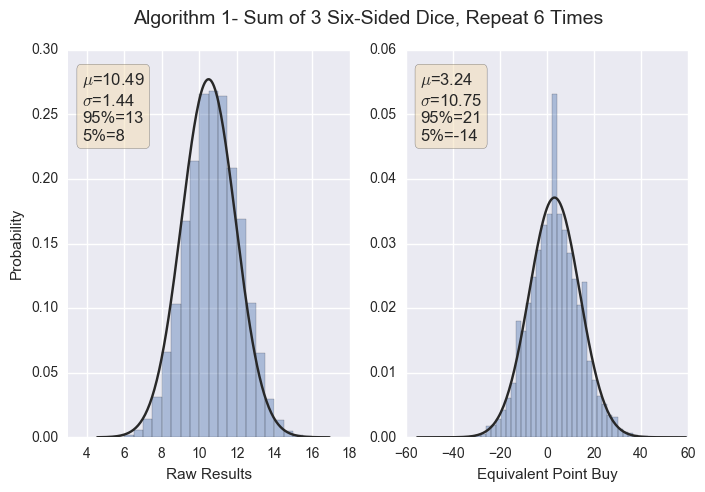

In [3]:
alg1_raw, alg1_val = mc_solution(10**5, 3, 6)
plot_hist(alg1_raw, alg1_val, "Algorithm 1- Sum of 3 Six-Sided Dice, " +
          "Repeat 6 Times", 23)

The mean of the raw results is approximately 10.5, which is exactly what is expected from a statistical solution, since each dice roll has an average of 3.5 (3.5 * 3 = 10.5). The 5% and 95% percentiles are also given, and can be interpreted as "90% of the values of the distribution fall between these two numbers".

The Equivalent Point Buy is not exactly equal to 0, because the value mapping is not symmetric (high rolls "cost" more than low rolls "give"). The mean Point Buy (approximately 3) can be interpreted as the average "cost" to "buy" a distribution that is similar to Algorithm 1 (i.e. actually randomly rolling the dice). Notice, though, that the variance seems extremely high. 90% of the time, we expect the Equivalent Point Buy to fall between -14 and 21.

### Algorithm 2- Sum of 3 Six-Sided Dice, Repeat 7 Times, Drop Lowest
The second algorithm is "Roll 3 six-sided dice and take the sum. Repeat 7 times, drop the lowest of the 7 times." Intuitively, this algorithm should have a higher expected value than algorithm 1, because there is an extra chance to roll 3 dice compared to Algorithm 1, and we are discarding the worst one.

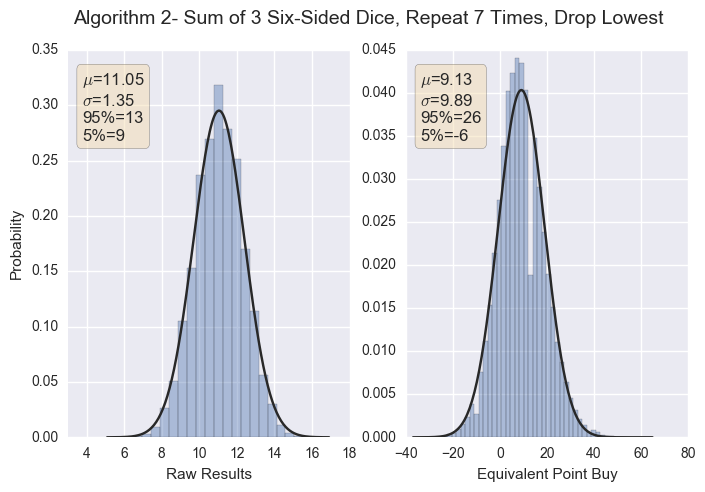

In [4]:
alg2_raw, alg2_val = mc_solution(10**5, 3, 7, drop_low_rep=True)
plot_hist(alg2_raw, alg2_val, "Algorithm 2- Sum of 3 Six-Sided Dice, " + 
          "Repeat 7 Times, Drop Lowest", 23)

Notice that for the raw results, both the mean and 5% confidence interval increased. The Equivalent Point Buy distribution changed significantly, increasing to a mean of 9 with 90% of the distribution between -6 and 26. *Note- all these algorithms will be compared in tabular form in the Summary section.*

### Algorithm 3- Sum of 3 Six-Sided Dice, Repeat 9 Times, Keep Best 6
The third algorithm is "Roll 3 six-sided dice and take the sum. Repeat 9 times, keep the best six rolls." We should expect similar results as for Algorithm 2, but slightly improved.

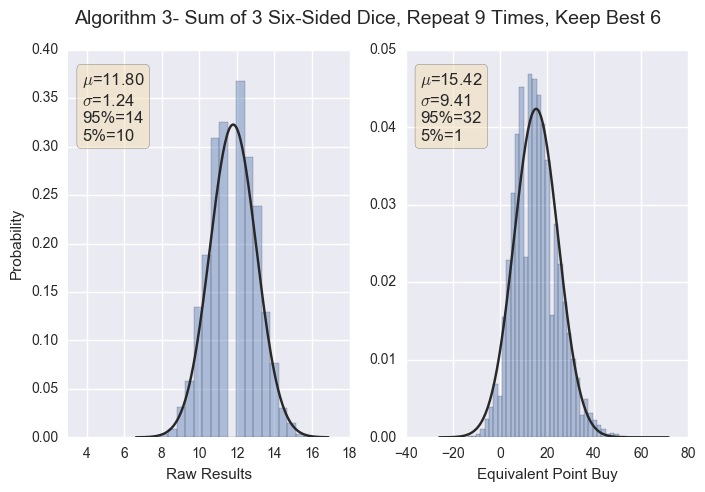

In [5]:
alg3_raw, alg3_val = mc_solution(10**5, 3, 9, drop_low_rep=True)
plot_hist(alg3_raw, alg3_val, "Algorithm 3- Sum of 3 Six-Sided Dice, " + 
          "Repeat 9 Times, Keep Best 6", 21)

In fact, the results improved more than expected. The mean Equivalent Point Buy is now approximately 15, increased from 9 for Algorithm 2. This is because there are now 3 chances to drop the lowest value, compared to 1.

### Algorithm 4- Sum of 4 Six-Sided Dice, Drop Lowest, Repeat 6 Times
The fourth algorithm is "Roll 4 six-sided dice, drop the lowest, and take the sum. Repeat 6 times." Before we run the code, let's think about the algorithm and how we might expect the results to compare to Algorithm 1. We should qualitatively expect that the mean should increase more than it did for Algorithm 2, because there are more chances to drop a low result (one chance for Algorithm 2, six chances for Algorithm 3).

Let's see if we were right:

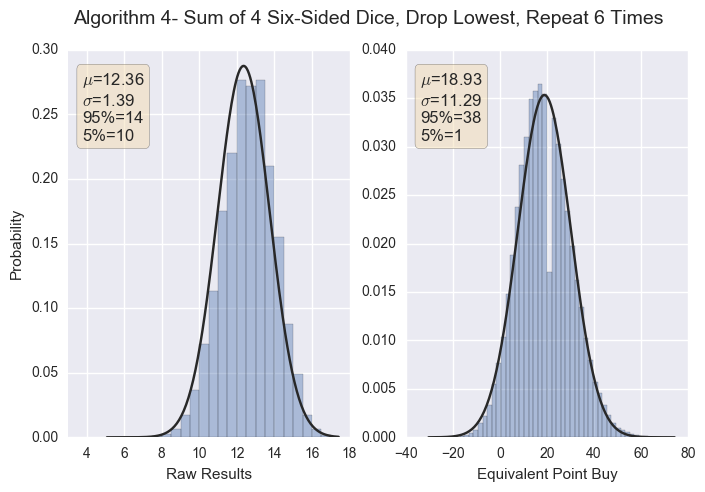

In [6]:
alg4_raw, alg4_val = mc_solution(10**5, 4, 6, drop_low_dice=True)
plot_hist(alg4_raw, alg4_val, "Algorithm 4- Sum of 4 Six-Sided Dice, " + 
          "Drop Lowest, Repeat 6 Times", 23)

As expected, the mean of the raw results distribution increased significantly more than for Algorithm 2, with 90% of the distribution falling between 10 and 14.5. The mean Equivalent Point Buy is now roughly 19, which is double that of Algorithm 2.

### Algorithm 5- Sum of 4 Six-Sided Dice, Drop Lowest, Repeat 7 Times, Drop Lowest
The fifth algorithm is "Roll 4 six-sided dice, drop the lowest, and take the sum. Repeat 7 times, drop the lowest of the 7 times." Essentially, this is the "best of both worlds" from Algorithms 2 and 4. Intuitively, we should expect the distribution to shift to the right somewhat compared to Algorithm 4.

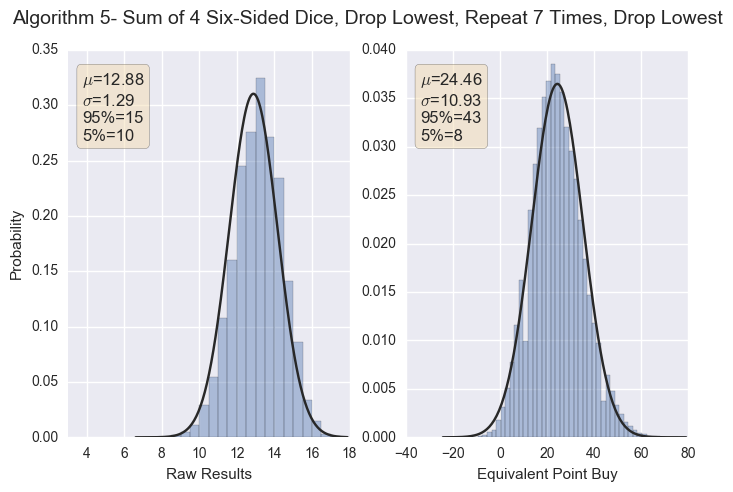

In [7]:
alg5_raw, alg5_val = mc_solution(10**5, 4, 7, drop_low_dice=True, drop_low_rep=True)
plot_hist(alg5_raw, alg5_val, "Algorithm 5- Sum of 4 Six-Sided Dice, " + 
          "Drop Lowest, Repeat 7 Times, Drop Lowest", 21)

### Algorithm 6- Sum of 2 Six-Sided Dice, Add 6, Repeat 6 Times
The sixth algorithm is "Roll 2 six-sided dice, add a third dice roll always equal to 6, and take the sum. Repeat 6 times." It's a little unclear how this algorithm will compare to the others. Essentially, we are always replacing the lowest value with the highest possible value, so the expected value should definitely be higher than for Algorithm 4, which only dropped the minimum of 3 rolls. Let's try it out:

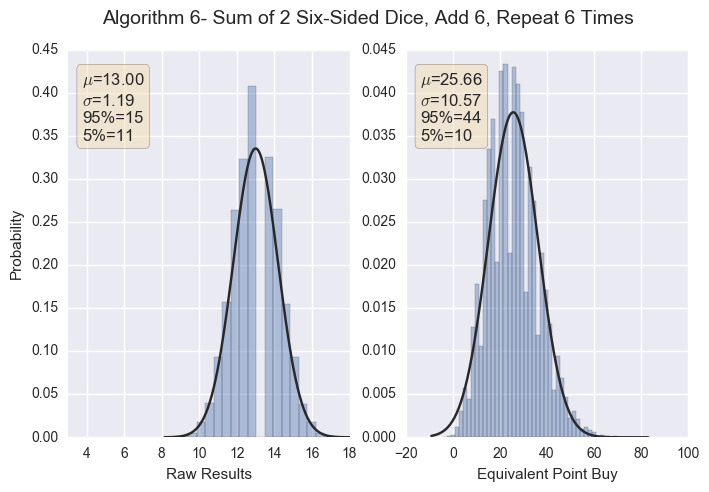

In [8]:
alg6_raw, alg6_val = mc_solution(10**5, 2, 6, add_six=True)
plot_hist(alg6_raw, alg6_val, "Algorithm 6- Sum of 2 Six-Sided Dice, " + 
          "Add 6, Repeat 6 Times", 21)

In fact, this algorithm achieved the highest expected value so far. Notice that the variance is also the lowest of any algorithm so far, since we are replacing one "random" dice with a dice that always gives a value of 6.

### Algorithm 7- Sum of 5 Six-Sided Dice, Drop the 2 Lowest, Repeat 6 Times
The seventh algorithm is "Roll 5 six-sided dice, drop the two lowest, and take the sum. Repeat 6 times." Intuitively, we might expect this algorithm to give the "best" results of all the algorithms, since we are dropping the lowest value 12 times, compared to 6 times for Algorithm 5, 3 times for Algorithm 3, and 1 time for Algorithm 2.

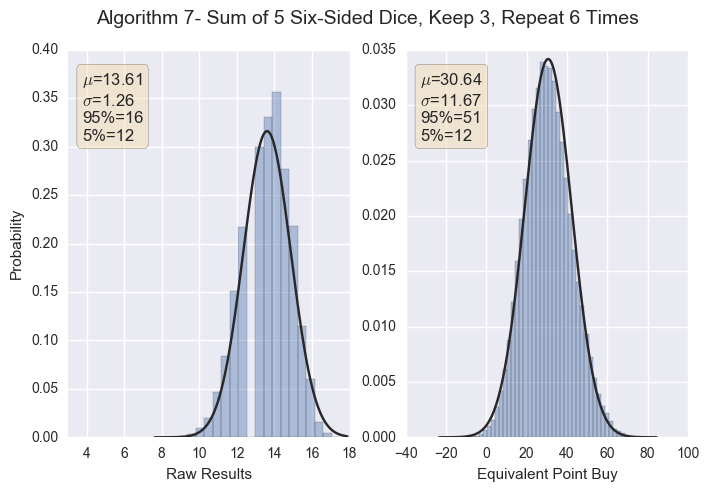

In [9]:
alg7_raw, alg7_val = mc_solution(10**5, 5, 6, drop_low_dice=True)
plot_hist(alg7_raw, alg7_val, "Algorithm 7- Sum of 5 Six-Sided Dice, " + 
          "Keep 3, Repeat 6 Times", 21)

As expected, we were correct. This algorithm has an Equivalent Point Buy of approximately 30, which is massive compared to Algorithm 1.

### Summary of Results
The following table summarizes the raw results from each of the seven algorithms:

In [10]:
def br(data, description):
    return [description, round(np.mean(data),2), round(np.std(data),2), 
            round(np.percentile(data,5),0), round(np.percentile(data,95),0)]

raw_res = [["Description","Mean","Std","5%","95%"],
           br(alg1_raw, "1. Sum of 3 Six-Sided Dice, Repeat 6 Times"),
           br(alg2_raw, "2. Sum of 3 Six-Sided Dice, Repeat 7 Times, Drop Lowest"),
           br(alg3_raw, "3. Sum of 3 Six-Sided Dice, Repeat 9 Times, Keep Best 6"),
           br(alg4_raw, "4. Sum of 4 Six-Sided Dice, Drop Lowest, Repeat 6 Times"),
           br(alg5_raw, "5. Sum of 4 Six-Sided Dice, Drop Lowest, Repeat 7 Times, Drop Lowest"),
           br(alg6_raw, "6. Sum of 2 Six-Sided Dice, Add 6, Repeat 6 Times"),
           br(alg7_raw, "7. Sum of 5 Six-Sided Dice, Drop the 2 Lowest, Repeat 6 Times")]
print("Raw Results")
print(tabulate(raw_res))

Raw Results
--------------------------------------------------------------------  -----  ----  ----  ----
Description                                                           Mean   Std   5%    95%
1. Sum of 3 Six-Sided Dice, Repeat 6 Times                            10.49  1.44  8.0   13.0
2. Sum of 3 Six-Sided Dice, Repeat 7 Times, Drop Lowest               11.05  1.35  9.0   13.0
3. Sum of 3 Six-Sided Dice, Repeat 9 Times, Keep Best 6               11.8   1.24  10.0  14.0
4. Sum of 4 Six-Sided Dice, Drop Lowest, Repeat 6 Times               12.36  1.39  10.0  14.0
5. Sum of 4 Six-Sided Dice, Drop Lowest, Repeat 7 Times, Drop Lowest  12.88  1.29  10.0  15.0
6. Sum of 2 Six-Sided Dice, Add 6, Repeat 6 Times                     13.0   1.19  11.0  15.0
7. Sum of 5 Six-Sided Dice, Drop the 2 Lowest, Repeat 6 Times         13.61  1.26  12.0  16.0
--------------------------------------------------------------------  -----  ----  ----  ----


The following table summarizes the Equivalent Point Buy results:

In [11]:
val_res = [["Description","Mean","Std","5%","95%"],
           br(alg1_val, "1. Sum of 3 Six-Sided Dice, Repeat 6 Times"),
           br(alg2_val, "2. Sum of 3 Six-Sided Dice, Repeat 7 Times, Drop Lowest"),
           br(alg3_val, "3. Sum of 3 Six-Sided Dice, Repeat 9 Times, Keep Best 6"),
           br(alg4_val, "4. Sum of 4 Six-Sided Dice, Drop Lowest, Repeat 6 Times"),
           br(alg5_val, "5. Sum of 4 Six-Sided Dice, Drop Lowest, Repeat 7 Times, Drop Lowest"),
           br(alg6_val, "6. Sum of 2 Six-Sided Dice, Add 6, Repeat 6 Times"),
           br(alg7_val, "7. Sum of 5 Six-Sided Dice, Drop the 2 Lowest, Repeat 6 Times")]
print("Equivalent Point Buy")
print(tabulate(val_res))

Equivalent Point Buy
--------------------------------------------------------------------  -----  -----  -----  ----
Description                                                           Mean   Std    5%     95%
1. Sum of 3 Six-Sided Dice, Repeat 6 Times                            3.24   10.75  -14.0  21.0
2. Sum of 3 Six-Sided Dice, Repeat 7 Times, Drop Lowest               9.13   9.89   -6.0   26.0
3. Sum of 3 Six-Sided Dice, Repeat 9 Times, Keep Best 6               15.42  9.41   1.0    32.0
4. Sum of 4 Six-Sided Dice, Drop Lowest, Repeat 6 Times               18.93  11.29  1.0    38.0
5. Sum of 4 Six-Sided Dice, Drop Lowest, Repeat 7 Times, Drop Lowest  24.46  10.93  8.0    43.0
6. Sum of 2 Six-Sided Dice, Add 6, Repeat 6 Times                     25.66  10.57  10.0   44.0
7. Sum of 5 Six-Sided Dice, Drop the 2 Lowest, Repeat 6 Times         30.64  11.67  12.0   51.0
--------------------------------------------------------------------  -----  -----  -----  ----


### Interpretation

As some may have guessed, this analysis is relevant for classic tabletop gaming. If a GM allows players to decide between Point Buy or random rolling, it is suggested that they choose the random rolling method that gives the closest expected value to the Equivalent Point Buy, such as:

**5-Point Buy**
* Sum of 3 Six-Sided Dice, Repeat 6 Times

**10-Point Buy**
* Sum of 3 Six-Sided Dice, Repeat 7 Times, Drop Lowest

**15-Point Buy**
* Sum of 3 Six-Sided Dice, Repeat 9 Times, Keep Best 6

**20-Point Buy**
* Sum of 4 Six-Sided Dice, Drop Lowest, Repeat 6 Times

**25-Point Buy**
* Sum of 4 Six-Sided Dice, Drop Lowest, Repeat 7 Times, Drop Lowest
* Sum of 2 Six-Sided Dice, Add 6, Repeat 6 Times

**30-Point Buy**
* Sum of 5 Six-Sided Dice, Drop the 2 Lowest, Repeat 6 Times

Note, of course, that random rolling has an associated uncertainty, and the 5% and 95% percentiles must be considered as well. 90% of the distribution will fall between those two values, so determine if an extremely lucky (or unlucky) player will still fit well within your planned game.